In [15]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [16]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST TRAIN/YES TRAIN/NO TEST/YES TEST/NO
!tree -d

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
.
├── drive
│   └── MyDrive
│       ├── Colab Notebooks
│       │   ├── Brain Tumor Detection 2.0
│       │   │   ├── Testing
│       │   │   │   ├── glioma
│       │   │   │   ├── meningioma
│       │   │   │   ├── notumor
│       │   │   │   └── pituitary
│       │   │   └── Training
│       │   │       ├── glioma
│       │   │       ├── meningioma
│       │   │       ├── notumor
│       │   │       └── pituitary
│       │   ├── Datasets
│       │   │   ├── Brain 

In [17]:
IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/Datasets/Brain tumor detection/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.') and CLASS != 'brain_tumor_dataset':
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(CLASS, " : ", IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
print("Training data: \n Yes ==> ", len(os.listdir("TRAIN/YES")), " \n No ==> ", len(os.listdir("TRAIN/NO")))
print("Testing data: \n Yes ==> ", len(os.listdir("TEST/YES")), "\n No ==> ", len(os.listdir("TEST/NO")))

no  :  98
yes  :  155
Training data: 
 Yes ==>  150  
 No ==>  93
Testing data: 
 Yes ==>  5 
 No ==>  5


In [18]:
dataset_dir = "/content/TRAIN"
test_dir = "/content/TEST"

In [19]:
#intializing the image size and batch size
height = 244
width = 244
batch_size = 32

In [20]:
def image_gen(height, width, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    test_gen = ImageDataGenerator(
        rescale=1./255.
    )

    test_ds = test_gen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    return train_ds, val_ds, test_ds

In [21]:
def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    return train_ds

In [22]:
train_ds, val_ds, test_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels, test_ds.labels])

# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 219 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
{'No brain tumor cases': 98, 'Brain tumor cases': 155}


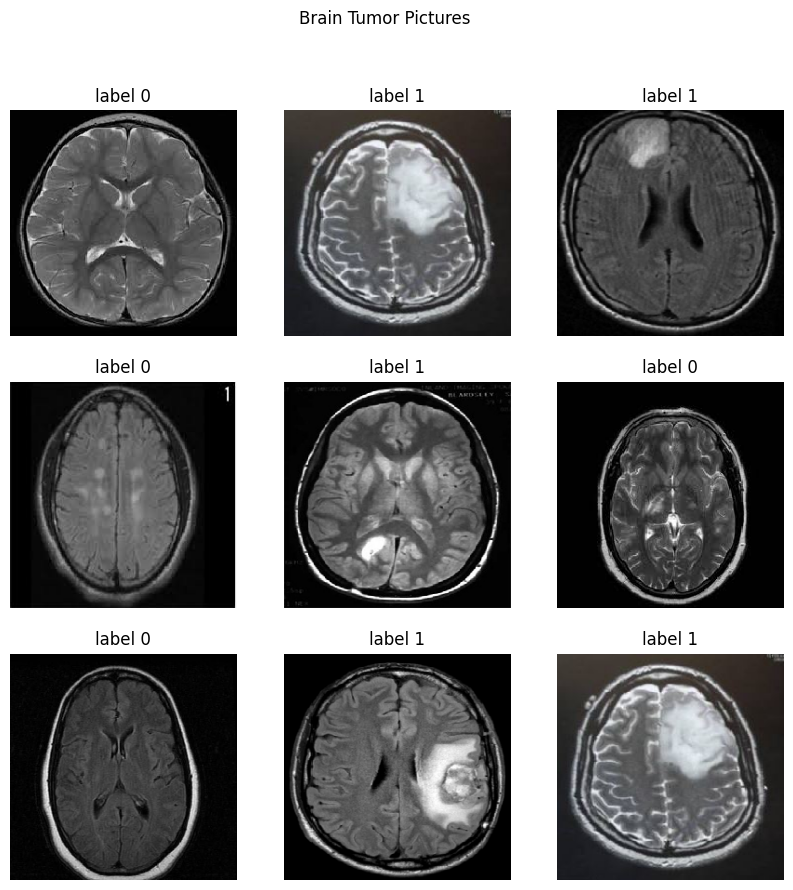

In [23]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

In [24]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [25]:
#Declaring base model
tf.keras.backend.clear_session()

base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model1.compile(optimizer=Adam(),
               loss="sparse_categorical_crossentropy",
               metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [26]:
history = model1.fit(train_ds, validation_data=val_ds, epochs = 25)

Epoch 1/25
7/7 [==============================] - 58s 8s/step - loss: 0.7201 - accuracy: 0.6941 - val_loss: 0.6195 - val_accuracy: 0.7083
Epoch 2/25
7/7 [==============================] - 57s 8s/step - loss: 0.3918 - accuracy: 0.8311 - val_loss: 0.2388 - val_accuracy: 0.9167
Epoch 3/25
7/7 [==============================] - 51s 8s/step - loss: 0.2954 - accuracy: 0.8767 - val_loss: 0.1474 - val_accuracy: 0.9583
Epoch 4/25
7/7 [==============================] - 50s 7s/step - loss: 0.1744 - accuracy: 0.9315 - val_loss: 0.1266 - val_accuracy: 0.9583
Epoch 5/25
7/7 [==============================] - 51s 7s/step - loss: 0.1558 - accuracy: 0.9406 - val_loss: 0.1630 - val_accuracy: 0.9583
Epoch 6/25
7/7 [==============================] - 56s 8s/step - loss: 0.1420 - accuracy: 0.9406 - val_loss: 0.1415 - val_accuracy: 0.9583
Epoch 7/25
7/7 [==============================] - 56s 8s/step - loss: 0.0872 - accuracy: 0.9543 - val_loss: 0.1223 - val_accuracy: 0.9583
Epoch 8/25
7/7 [==================

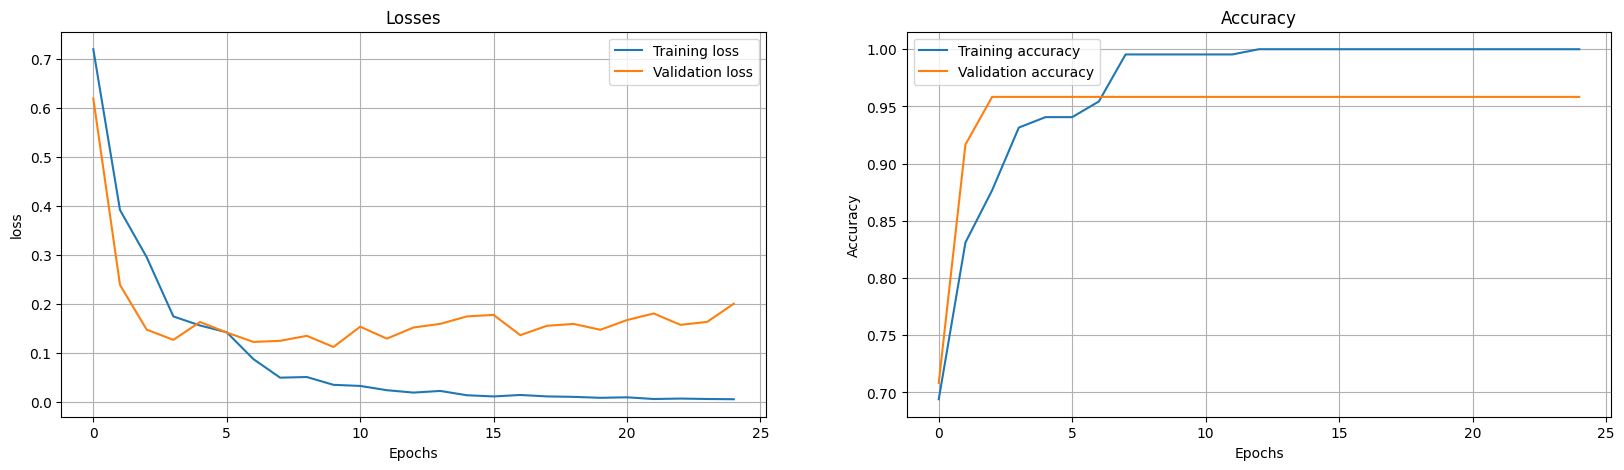

In [27]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [30]:
aug_train_ds = augmented_data(height, width)
history = model1.fit(aug_train_ds, validation_data=val_ds, epochs = 25)

Found 243 images belonging to 2 classes.
Epoch 1/25
8/8 [==============================] - 69s 9s/step - loss: 0.3657 - accuracy: 0.8683 - val_loss: 0.2408 - val_accuracy: 0.9583
Epoch 2/25
8/8 [==============================] - 66s 9s/step - loss: 0.2436 - accuracy: 0.9053 - val_loss: 0.2367 - val_accuracy: 0.9583
Epoch 3/25
8/8 [==============================] - 66s 8s/step - loss: 0.1897 - accuracy: 0.9342 - val_loss: 0.1530 - val_accuracy: 0.9583
Epoch 4/25
8/8 [==============================] - 59s 7s/step - loss: 0.1601 - accuracy: 0.9506 - val_loss: 0.0531 - val_accuracy: 1.0000
Epoch 5/25
8/8 [==============================] - 63s 8s/step - loss: 0.1210 - accuracy: 0.9588 - val_loss: 0.0423 - val_accuracy: 1.0000
Epoch 6/25
8/8 [==============================] - 65s 8s/step - loss: 0.1273 - accuracy: 0.9588 - val_loss: 0.0474 - val_accuracy: 1.0000
Epoch 7/25
8/8 [==============================] - 69s 9s/step - loss: 0.0941 - accuracy: 0.9671 - val_loss: 0.1000 - val_accuracy: 

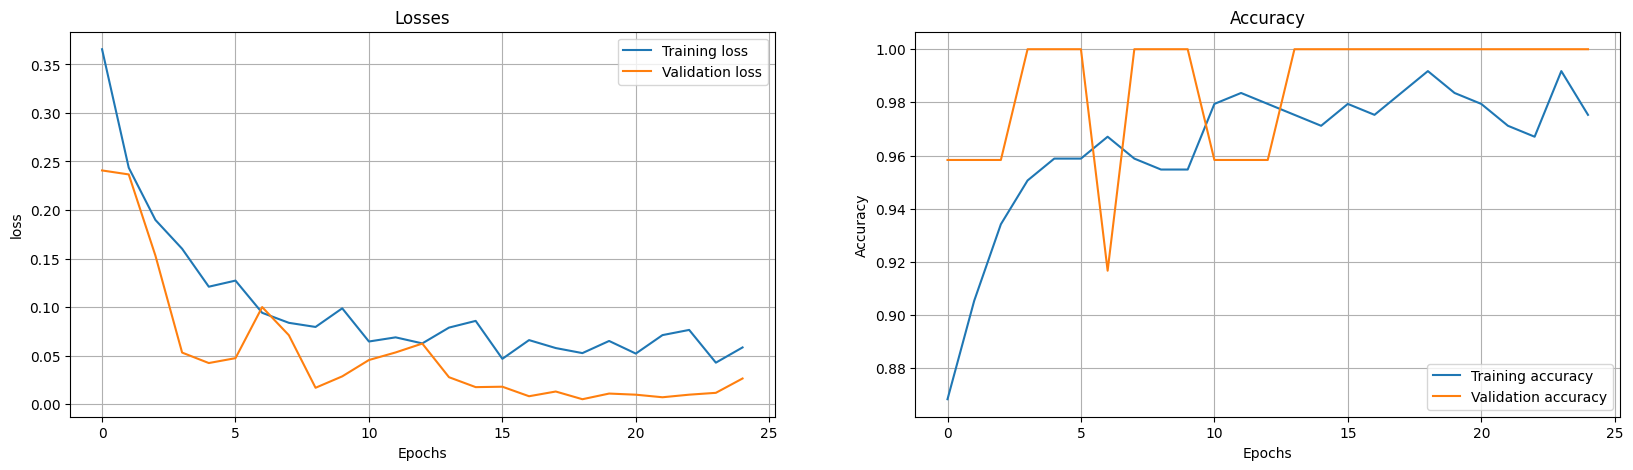

In [31]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()